# Simple Recurrent Model

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [232]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'tokenized'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [233]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import seaborn as sns
import torch
import wandb

# For resolving the below issue with Colab and plotly:
# https://stackoverflow.com/questions/69564817/typeerror-load-missing-1-required-positional-argument-loader-in-google-col
!pip install pyyaml==5.4.1

`wandb` log in:

In [234]:
wandb.login()

True

Google drive access

In [235]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [236]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text utils to be instantianted in the notebook

In [237]:
notebook_model = avm.LitEmbeddingRNNAV
notebook_datamodule = avm.EmbeddingDataModuleAV
notebook_encoder = avm.str_to_idxs 
notebook_decoder = avm.idxs_to_str
notebook_wandb_pred_callback = avm.WandbAVPredictionCallback
notebook_wandb_embedding_callback = avm.WandbVisualEmbeddingCallback

Copy data to cwd for speed.

In [238]:
train_text_file_name = 'balanced_filtered_normalized_data_train.feather'
val_text_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_text_path = FOLDERNAME + SUBDIR + train_text_file_name
val_text_path = FOLDERNAME + SUBDIR + val_text_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_text_path}' .
!cp '{val_text_path}' .
!cp '{tokens_path}' .
train_text_df = pd.read_feather(train_text_file_name)
val_text_df = pd.read_feather(val_text_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = avm.char_to_idx_dict_from_df(tokens_df)
    idx_to_text = avm.idx_to_char_dict_from_df(tokens_df)
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings and not included
    # in tokens_df
    text_to_idx = avm.word_to_idx_dict_from_df(tokens_df)
    idx_to_text = avm.idx_to_word_dict_from_df(tokens_df)
with open(FOLDERNAME + SUBDIR + 'heatmap_words.txt', 'r') as f:
    heatmap_words = f.read().split()
with open(FOLDERNAME + SUBDIR + 'pca_words.txt', 'r') as f:
    pca_words =f.read().split()
with open(FOLDERNAME + SUBDIR + 'tsne_words.txt', 'r') as f:
    tsne_words = f.read().split()

The `tokens_df` used for embedding layers currently has every word found in the training set, regardless of length or how common it is. Many words are rarely used:

In [239]:
tokens_df.describe()

,count
count,23946.000000
mean,14.654640
std,209.052981
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,16881.000000


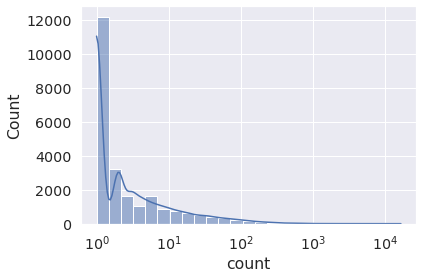

In [240]:
sns.histplot(data=tokens_df, x='count', kde=True, bins=25, log_scale=True)

Plot what percent of all words and what percent of entries in the training set are removed if we only include words which appear more than `n` times, for varying choices of `n`:

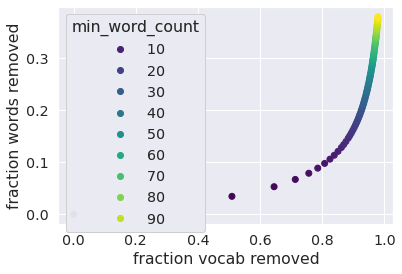

In [241]:
def vocab_words_removed(n, df):
    df = df.copy()
    filtered_df = df.loc[lambda x: x['count'] >= n]
    vocab_fraction_removed = 1- len(filtered_df) / len(df)
    words_fraction_removed = 1 - filtered_df['count'].sum() / df['count'].sum()
    return (vocab_fraction_removed, words_fraction_removed)

removed_data = [vocab_words_removed(n, tokens_df) for n in range(1, 100)]
fig, ax = plt.subplots(1, 1)
scatter = ax.scatter(*zip(*removed_data),
                     c=np.arange(1, len(removed_data) + 1),
                     cmap='viridis')
ax.set_xlabel('fraction vocab removed')
ax.set_ylabel('fraction words removed')
legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="upper left", 
                    title="min_word_count")
ax.add_artist(legend1)
fig.savefig(FOLDERNAME + '/figures/embedding_vocab_words_removed_plot.svg')

We can pass a `min_word_count` arg (default `1`) to the architecture and datamodules which will filter the vocab to only include words with `count >= min_word_count` `tokens_df`. (This filtering crucially assumes lower-indexed words have a higher count than higher-indexed ones).

In [242]:
MIN_WORD_COUNT = 1
print(vocab_words_removed(MIN_WORD_COUNT, tokens_df))

(0.0, 0.0)


Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [243]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Thu Jan 27 21:34:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    37W / 300W |   1627MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [244]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_recurrent_embedding


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [245]:
val_text_intersections_filtered_df = val_text_df.merge(train_text_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_text_df) - len(val_text_intersections_filtered_df)} items removed from val set, {100 * (len(val_text_df) - len(val_text_intersections_filtered_df)) / len(val_text_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [246]:
print(train_text_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [247]:
print(val_text_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [248]:
model_args_dict = {'seq_len': SEQ_LEN,
                  'min_word_count': MIN_WORD_COUNT,
                  'tokens_df': tokens_df,
                  'num_layers': 1,
                  'hidden_size': 512,
                  'rnn_type': 'GRU',
                  'bidirectional': False,
                  'hidden_strategy': 'concat',
                  'embedding_dim': 256,
                  'zero_fc_bias_init': True,
                  }
data_args_dict = {'seq_len': SEQ_LEN,
                  'min_word_count': MIN_WORD_COUNT,
                 'train_text_df': train_text_df,
                 'val_text_df': val_text_intersections_filtered_df,
                 'tokens_df': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'num_workers': NUM_PROCESSORS,
                 'batch_size': 128,
                 'pin_memory': IS_CUDA_AVAILABLE,
                 'persistent_workers': True
                 }

Small test run.

In [252]:
small_data_module = notebook_datamodule(**{**data_args_dict, **{'sample_size': .5}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, idx_to_text).strip()
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dict)
print('Model layers:', small_model)
small_preds, small_losses, _ = small_model.get_scores_loss_last_hiddens(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', -np.log(.5))

text: new theory on the hall effect
len: 29
source: True
text: integrating cad and numerical analysis : ' dirty geometry ' handling using the finite cell method
len: 97
source: False
text: communication dimensions of matter , energy and information
len: 59
source: True


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Model layers: LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=1536, out_features=1, bias=True)
  )
)

preds sh

In [253]:
# pl implements gradient clipping through the Trainer.
small_trainer = Trainer(gpus=-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1,
                        gradient_clip_val=1,
                        precision=16,
                        profiler='simple',
                        )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  7.508          	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  5.0884         	|1              	|  5.0884         	|  67.773         	|
run_training_batch                 	|  0.034364       	|97             	|  3.3333         	|  44.397         	|
optimizer_step_with_closure_0      	|  0.033852       	|97             	|  3.2836         	|  43.735         	|
training_step_and_backward         	|  0.030927       	|97             	|  3.0            	|  39.957         	|
model_forward                      

Suggested lr: 0.005754399373371567


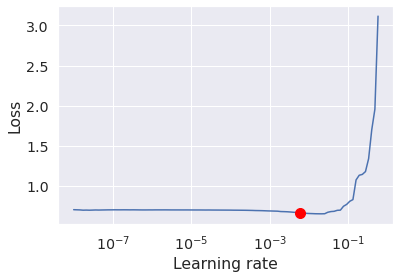

In [254]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: {small_trainer_suggested_lr}')

In [255]:
small_trainer.fit(small_model, datamodule=small_data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params
--------------------------------------------------
0 | train_metrics_dict | ModuleDict | 0     
1 | val_metrics_dict   | ModuleDict | 0     
2 | test_metrics_dict  | ModuleDict | 0     
3 | embedding          | Embedding  | 6.1 M 
4 | rnn                | GRU        | 1.2 M 
5 | fc_layers          | ModuleList | 1.5 K 
--------------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
14.631    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "
FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  24.85          	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  6.7605         	|2              	|  13.521         	|  54.411         	|
run_training_batch               

# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `sweep_fixed_model_args_dict`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `sweep_fixed_model_args_dict` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [ ]:
sweep_fixed_model_args_dict = {**deepcopy(model_args_dict), 
                               **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': np.log(1e-3).item(),
                                      'max': np.log(1e-2).item()
                                      },
                               'fc_dropout': {'distribution': 'uniform',
                                      'min': .5,
                                      'max': .9
                                      },
                               'hidden_strategy': {'values': ["last", "max", "mean", "concat"]}
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `sweep_fixed_model_args_dict` for logging purposes.

In [ ]:
# Setting 'batch_size' in sweep_data_args_dict controls the batch size, while setting
# this key in sweep_fixed_model_args_dict just lets wandb track this hyperparameter.
sweep_data_args_dict = deepcopy(data_args_dict)
sweep_data_args_dict['batch_size'] = sweep_fixed_model_args_dict['batch_size'] = 2 ** 11

# Set max_epochs in a dict, along with any other optional trainer kwargs.
sweep_trainer_dict = {'max_epochs': 64,
                      'gradient_clip_val': 1,
                      }

# Merge sweep_trainer_dict into sweep_fixed_model_args_dict for logging purposes.
sweep_fixed_model_args_dict = {**sweep_fixed_model_args_dict, **sweep_trainer_dict}

def sweep_val_examples(sample_size=512,
                       datamodule_args=sweep_data_args_dict):
    """Taking random samples from the validation set for callback visualization.
    """
    val_sample_module = notebook_datamodule(**{**datamodule_args,
                                               **{'sample_size': sample_size}})
    val_sample_module.setup()
    val_sample  = next(iter(val_sample_module.val_dataloader()))
    return val_sample

def sweep_trainer(model):
    """Encapsulating the trainer used for wandb sweeps.
    """
    trainer = Trainer(logger=WandbLogger(),
                      gpus=-1 if IS_CUDA_AVAILABLE else 0,
                      log_every_n_steps=1,
                      precision=16,
                      profiler='simple',
                      callbacks=[notebook_wandb_pred_callback(val_sample=sweep_val_examples(),
                                                         decoder_fn=notebook_decoder,
                                                         decoder_dict=idx_to_text,
                                                         labels=('arxiv', 'vixra')),
                                 EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               check_on_train_epoch_end=False,
                                               patience=5,
                                               verbose=True),
                                 notebook_wandb_embedding_callback(model=model,
                                                    heatmap_words=heatmap_words,
                                                    pca_words=pca_words,
                                                    tsne_words=tsne_words,
                                                    word_to_idx_dict=text_to_idx,
                                                    idx_to_word_dict=idx_to_text,
                                                    k=5,
                                                    heatmap_title=f'{PROJECT} Cosine Heatmap',
                                                    pca_title=f'{PROJECT} PCA',
                                                    tsne_title=f'{PROJECT} t-SNE',
                                                    ),
                                 LearningRateMonitor()
                                 ],
                      num_sanity_val_steps=-1,
                      **sweep_trainer_dict
                      )
    return trainer

def sweep_iteration():
    """The wandb sweep iteration function. To be passed to wandb.agent.
    """
    # There seems to be a 128 char limit on the group_str
    group_str = '-'.join(sorted([f'{key}_{val}' for key, val in sweep_fixed_model_args_dict.items() if key != 'tokens']))[:128]
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**sweep_data_args_dict)
        config = wandb.config
        # Overwrite the random run names chosen by wandb.
        run.name = '-'.join(sorted([f'{key}_{val}' for key, val in config.items()]))[:128]
        # Merge config into remaining parameters.
        config = {**sweep_fixed_model_args_dict, **config}
        model = notebook_model(**config)
        print(50 * '-',
              'Model Architecture:',
              model,
              50 * '-',
              sep='\n')
        trainer = sweep_trainer(model)
        trainer.fit(model, 
                    datamodule=data)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: i9qsme15
Sweep URL: https://wandb.ai/garrett361/balanced_title_recurrent_embedding/sweeps/i9qsme15


In [ ]:
wandb.agent(sweep_id, function=sweep_iteration)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: ci4kl45c with config:
wandb: 	fc_dropout: 0.8117259080280906
wandb: 	hidden_strategy: concat
wandb: 	lr: 0.0065452675552778805


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'hidden_strategy' was locked by 'sweep' (ignore

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6984503865242004
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6984503865242004


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7712339758872986
Validation Loss: 0.46302172541618347
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7712339758872986
Validation Loss: 0.46302172541618347


Metric val_loss improved. New best score: 0.463
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.825988233089447
Validation Loss: 0.3961503505706787
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.825988233089447
Validation Loss: 0.3961503505706787


Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.396
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.8377403616905212
Validation Loss: 0.3887575566768646
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.8377403616905212
Validation Loss: 0.3887575566768646


Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.389
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:256: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▇██████
best_val_loss,█▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
global_step,▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇██
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▆▇▇███
train_auroc,▁▅▇▇████
train_avg_precision,▁▅▇▇████
train_batch_loss,█▇▆▆▅▅▅▅▄▅▃▄▃▃▃▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_epoch_loss,█▆▄▃▂▁▁▁
train_f1,▁▅▆▇▇███


wandb: Agent Starting Run: 0f75cbjn with config:
wandb: 	fc_dropout: 0.5040588232539998
wandb: 	hidden_strategy: concat
wandb: 	lr: 0.001653297206846801


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'hidden_strategy' was locked by 'sweep' (ignore

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.502136766910553
Validation Loss: 0.7093172073364258
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.502136766910553
Validation Loss: 0.7093172073364258


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7641559839248657
Validation Loss: 0.4900405704975128
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7641559839248657
Validation Loss: 0.4900405704975128


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7924679517745972
Validation Loss: 0.43773022294044495
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7924679517745972
Validation Loss: 0.43773022294044495


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.80982905626297
Validation Loss: 0.4076385796070099
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.80982905626297
Validation Loss: 0.4076385796070099


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.8214476704597473
Validation Loss: 0.3950214385986328
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.8214476704597473
Validation Loss: 0.3950214385986328


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8322649598121643
Validation Loss: 0.4067663252353668


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▄▆▇█████
best_val_loss,█▄▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
global_step,▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▅▆▇▇██
train_auroc,▁▄▅▆▇▇███
train_avg_precision,▁▄▆▆▇▇███
train_batch_loss,█▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▂▂▂▂▁▁▁▁
train_epoch_loss,█▆▅▄▄▃▂▂▁
train_f1,▁▄▅▆▆▇▇██


wandb: Agent Starting Run: t7hdwvqy with config:
wandb: 	fc_dropout: 0.5688650645625858
wandb: 	hidden_strategy: max
wandb: 	lr: 0.005818271100666214


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'hidden_strategy' was locked by 'sweep' (ignore

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6904571652412415
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6904571652412415


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7565438151359558
Validation Loss: 0.49250197410583496
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7565438151359558
Validation Loss: 0.49250197410583496


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.8000801205635071
Validation Loss: 0.4118977189064026
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.8000801205635071
Validation Loss: 0.4118977189064026


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.8297275900840759
Validation Loss: 0.3821932077407837
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.8297275900840759
Validation Loss: 0.3821932077407837


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.8360042572021484
Validation Loss: 0.40128183364868164


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▅▇█████
best_val_loss,█▃▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
global_step,▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇██
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▆▇▇███
train_auroc,▁▆▇▇████
train_avg_precision,▁▆▇▇████
train_batch_loss,▃█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_epoch_loss,█▅▄▃▂▂▁▁
train_f1,▁▅▆▇▇███


wandb: Agent Starting Run: 5gg1ueg3 with config:
wandb: 	fc_dropout: 0.5902791950089363
wandb: 	hidden_strategy: max
wandb: 	lr: 0.0038504393076263903


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'hidden_strategy' was locked by 'sweep' (ignore

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6950393319129944
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6950393319129944


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7799145579338074
Validation Loss: 0.47673001885414124
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7799145579338074
Validation Loss: 0.47673001885414124


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.813034176826477
Validation Loss: 0.4034774899482727
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.813034176826477
Validation Loss: 0.4034774899482727


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.8290598392486572
Validation Loss: 0.39549678564071655
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.8290598392486572
Validation Loss: 0.39549678564071655


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.8336004018783569
Validation Loss: 0.38724252581596375
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.8336004018783569
Validation Loss: 0.38724252581596375


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▅▇██████
best_val_loss,█▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
global_step,▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▆▇▇███
train_auroc,▁▅▆▇▇████
train_avg_precision,▁▅▆▇▇████
train_batch_loss,█▇▆▆▅▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_epoch_loss,█▆▅▄▃▂▂▁▁
train_f1,▁▄▆▆▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7d5jv6oy with config:
wandb: 	fc_dropout: 0.7776580801912025
wandb: 	hidden_strategy: mean
wandb: 	lr: 0.002480019333245148


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'hidden_strategy' was locked by 'sweep' (ignore

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6938923597335815
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6938923597335815


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7240918874740601
Validation Loss: 0.5200762152671814
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7240918874740601
Validation Loss: 0.5200762152671814


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7813835740089417
Validation Loss: 0.45487648248672485
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7813835740089417
Validation Loss: 0.45487648248672485


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.8138354420661926
Validation Loss: 0.41732653975486755
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.8138354420661926
Validation Loss: 0.41732653975486755


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.819978654384613
Validation Loss: 0.4240209758281708


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8246527910232544
Validation Loss: 0.42155522108078003


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▅▇█████
best_val_loss,█▄▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
global_step,▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇██
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▆▇▇██
train_auroc,▁▄▆▇▇▇██
train_avg_precision,▁▄▆▇▇███
train_batch_loss,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
train_epoch_loss,█▆▅▄▃▂▂▁
train_f1,▁▅▆▆▇▇██


wandb: Agent Starting Run: 2sqp4zau with config:
wandb: 	fc_dropout: 0.8910147490441351
wandb: 	hidden_strategy: max
wandb: 	lr: 0.0014611209214651867


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'hidden_strategy' was locked by 'sweep' (ignore

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.4985309839248657
Validation Loss: 0.7159151434898376
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.4985309839248657
Validation Loss: 0.7159151434898376


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7402510643005371
Validation Loss: 0.5561742186546326
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7402510643005371
Validation Loss: 0.5561742186546326


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7367788553237915
Validation Loss: 0.4930344223976135


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.78125
Validation Loss: 0.45215582847595215
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.78125
Validation Loss: 0.45215582847595215


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.7895299196243286
Validation Loss: 0.42523297667503357
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.7895299196243286
Validation Loss: 0.42523297667503357


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8072916865348816
Validation Loss: 0.41061174869537354
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.8072916865348816
Validation Loss: 0.41061174869537354


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.8179754018783569
Validation Loss: 0.3965410590171814
Saved best val_loss at global step: 107
Epoch: 5
Validation accuracy: 0.8179754018783569
Validation Loss: 0.3965410590171814


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 6
Validation accuracy: 0.8250533938407898
Validation Loss: 0.4047521948814392


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 8
Validation accuracy: 0.8263888955116272
Validation Loss: 0.4200909435749054


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 179
Epoch: 9
Validation accuracy: 0.8337339758872986
Validation Loss: 0.40874844789505005


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▁▄▅▆▇▇▇▇██
best_val_loss,█▅▃▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
global_step,▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▅▆▆▇▇▇██
train_auroc,▁▄▅▆▆▇▇▇███
train_avg_precision,▁▄▅▆▆▇▇▇███
train_batch_loss,█▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▃▂▂▂▁▁▂▂▁▁▁▁
train_epoch_loss,█▆▆▅▄▃▃▂▂▁▁
train_f1,▁▄▅▆▆▇▇▇███


wandb: Agent Starting Run: 80js3xvf with config:
wandb: 	fc_dropout: 0.8844646420967126
wandb: 	hidden_strategy: last
wandb: 	lr: 0.0010833027616270364


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Recall()
    (test_specificity): Specificity()
    (test_f1): F1()
    (test_auroc): AUROC()
    (test_avg_precision): AveragePrecision()
  )
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, batch_first=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'hidden_strategy' was locked by 'sweep' (ignore

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6935290694236755
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6935290694236755


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


# Load the Best Models

Load all runs recorded in `wandb` for this notebook.

In [43]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT)
run_cats = ('best_val_acc', 'name', 'wandb_path', 'hidden_strategy', 'timestamp')
runs_sort_cat = 'best_val_acc'
run_state_dict_file_name = 'model_best_val_acc.pt'
run_init_params_file_name = 'model_init_params.pt'
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    t = run.config
    if runs_sort_cat in run_json:
        notebook_runs_dict[runs_sort_cat].append(run_json[runs_sort_cat])
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
        notebook_runs_dict['hidden_strategy'].append(run.config['hidden_strategy'])
        notebook_runs_dict['timestamp'].append(run_json['_timestamp'])
# See top runs:
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by=runs_sort_cat, ascending=False).reset_index(drop=True)
best_model_df = notebook_runs_df.iloc[0]
best_model_wandb_path = best_model_df['wandb_path']
print(notebook_runs_df.head().to_string())
# Restore best model.
wandb.restore(run_state_dict_file_name, run_path = best_model_wandb_path, replace=True)
wandb.restore(run_init_params_file_name, run_path = best_model_wandb_path, replace=True)
# Write state dict and init params to final models folder.
!cp "{run_state_dict_file_name}" "{FOLDERNAME + '/final_models/' + PROJECT + '_state_dict.pt'}"
!cp "{run_init_params_file_name}" "{FOLDERNAME + '/final_models/' + PROJECT + '_init_params.pt'}"
best_model_state_dict = torch.load(run_state_dict_file_name)
best_model_init_params = torch.load(run_init_params_file_name)
print('\n', 50 * '-' + '\n', 'best model args:\n', best_model_init_params, sep='\n')
best_model = notebook_model(**best_model_init_params)
best_model.load_state_dict(torch.load(run_state_dict_file_name))

   best_val_acc                                          name                                              wandb_path hidden_strategy   timestamp
0      0.843616   hidden_strategy_max-lr_0.005230202421386029  garrett361/balanced_title_recurrent_embedding/r40nhubz             max  1642991475
1      0.841880  hidden_strategy_mean-lr_0.006943021394921448  garrett361/balanced_title_recurrent_embedding/ha02619q            mean  1642989997
2      0.840144   hidden_strategy_mean-lr_0.04168319406847725  garrett361/balanced_title_recurrent_embedding/zmhia0eq            mean  1642980508
3      0.840011   hidden_strategy_max-lr_0.010179855440374535  garrett361/balanced_title_recurrent_embedding/sbf87khe             max  1642990785
4      0.838942   hidden_strategy_max-lr_0.005163544275848698  garrett361/balanced_title_recurrent_embedding/10bm5tq1             max  1642978465


--------------------------------------------------

best model args:

"batch_size":                2048
"bidirectional":  

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

Fine-tuning:

In [19]:
# small_run_data_module = notebook_datamodule(**{**data_args_dict, **{'sample_size': .5}})
# # pl implements gradient clipping through the Trainer.
# small_run_trainer = Trainer(gpus=-1 if IS_CUDA_AVAILABLE else 0,
#                         max_epochs=1,
#                         gradient_clip_val=1,
#                         precision=16,
#                         profiler='simple',
#                         )
# best_model.save_models_to_wandb = False
# small_run_trainer_lr_finder = small_run_trainer.tuner.lr_find(best_model, datamodule=small_run_data_module, max_lr=1e-4)
# small_run_trainer_lr_finder_plot = small_run_trainer_lr_finder.plot(suggest=True)
# small_run_trainer_suggested_lr = small_run_trainer_lr_finder.suggestion()
# print(f'Suggested lr: {small_run_trainer_suggested_lr}')
# best_model.save_models_to_wandb = True

A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

In [20]:
# best_model.lr = 1e-5
# with wandb.init(project=PROJECT) as run:
#     run.name = ('ft_' + best_model_df['name'])[:128]
#     run_data_args_dict = {'seq_len': SEQ_LEN,
#                  'train_text_df': train_text_df,
#                  'val_text_df': val_text_intersections_filtered_df,
#                  'tokens_df': tokens_df, 
#                  'text_column': TEXT_FIELD,
#                  'num_workers': NUM_PROCESSORS,
#                  'batch_size': 2 ** 11,
#                  'pin_memory': IS_CUDA_AVAILABLE,
#                  'persistent_workers': True
#                  }
#     trainer = Trainer(logger=WandbLogger(),
#                       gpus=-1 if IS_CUDA_AVAILABLE else 0,
#                       log_every_n_steps=1,
#                       precision=16,
#      get_p                 profiler='simple',
#                       num_sanity_val_steps=-1,
#                       max_epochs=128,
#                       gradient_clip_val=1
#                       )
#     data = notebook_datamodule(**run_data_args_dict)
#     trainer.fit(best_model, 
#                     datamodule=data)

# My Papers

Finally, examine the model's results on my own papers:

In [96]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
print(goon_papers_df.to_string())

                                                                                 title source
0                        quantum corrections to generic branes : dbi , nlsm , and more  arxiv
1                    universal relation between corrections to entropy and extremality  arxiv
2                                                         primordial non - gaussianity  arxiv
3                                                superluminality , black holes and eft  arxiv
4             shapes of gravity : tensor non - gaussianity and massive spin - 2 fields  arxiv
5                                the effective theory of shift - symmetric cosmologies  arxiv
6                                           partially massless fields during inflation  arxiv
7                                      soft theorems for shift - symmetric cosmologies  arxiv
8                                                             heavy fields and gravity  arxiv
9                                            aspects of gali

Encode titles, stack into a tensor, and generate predictions:

In [22]:
best_model_word_to_idx = avm.word_to_idx_dict_from_df(best_model.tokens_df)
goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, best_model_word_to_idx, SEQ_LEN))], dim=0)
best_model_goon_probs_t, _ = best_model.get_probs_last_hiddens(goon_papers_t)
goon_papers_df['vixra_prob'] = best_model_goon_probs_t
print(f'Mean prediction: {best_model_goon_probs_t.mean().item()}')
print(f'Correct predictions: {(best_model_goon_probs_t < .5).sum()}/{goon_papers_t.shape[0]}')

Mean prediction: 0.2159399539232254
Correct predictions: 17/20


Visualized by title:

In [23]:
goon_papers_sorted_df = goon_papers_df.sort_values(by='vixra_prob', ascending=False).reset_index(drop=True)
print(goon_papers_sorted_df.to_string())

                                                                                 title source  vixra_prob
0      einstein gravity , massive gravity , multi - gravity and nonlinear realizations  arxiv    0.981325
1                                                     galileons as wess - zumino terms  arxiv    0.914901
2                    universal relation between corrections to entropy and extremality  arxiv    0.763630
3                                                superluminality , black holes and eft  arxiv    0.438435
4                                 massive gravity coupled to galileons is ghost - free  arxiv    0.209261
5                                                             heavy fields and gravity  arxiv    0.186783
6             shapes of gravity : tensor non - gaussianity and massive spin - 2 fields  arxiv    0.141711
7                                the effective theory of shift - symmetric cosmologies  arxiv    0.120964
8                                             

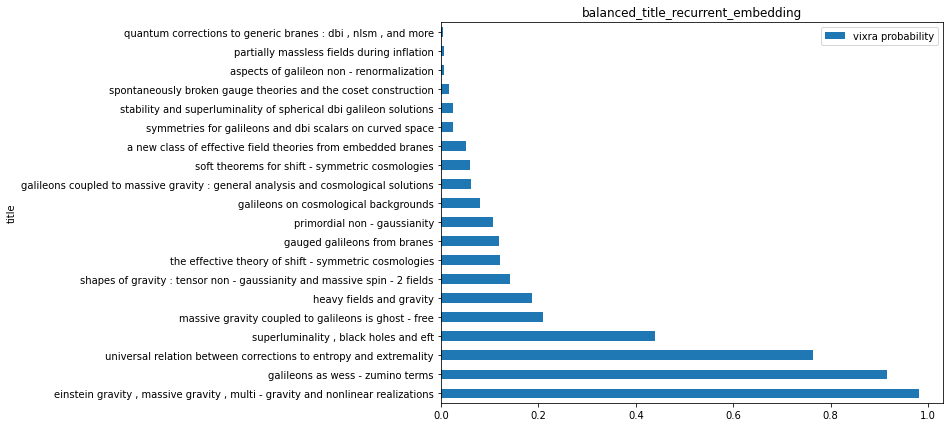

In [24]:
goon_papers_sorted_df_barh = goon_papers_sorted_df.plot.barh(x='title',
                                               y='vixra_prob',
                                               title=PROJECT, 
                                               figsize=(9, 7),
                                               label='vixra probability',
                                               legend=True)
goon_papers_sorted_df_barh.figure.savefig(FOLDERNAME + f'/figures/{PROJECT}_goon_papers_preds.svg', bbox_inches='tight')

# RNN Visualization

Visualizing what the RNN is picking up on.

It is easiest to interpret what models which use the 'last' strategy are doing:

In [44]:
notebook_runs_last_strat_df = notebook_runs_df[notebook_runs_df['hidden_strategy'] == 'last']
best_last_strat_model_df = notebook_runs_last_strat_df.iloc[0]
best_last_strat_model_wandb_path = best_last_strat_model_df['wandb_path']
wandb.restore(run_state_dict_file_name, run_path = best_last_strat_model_wandb_path, replace=True)
wandb.restore(run_init_params_file_name, run_path = best_last_strat_model_wandb_path, replace=True)
best_last_strat_model_state_dict = torch.load(run_state_dict_file_name)
best_last_strat_model_init_params = torch.load(run_init_params_file_name)
best_last_strat_model = notebook_model(**best_last_strat_model_init_params)
best_last_strat_model.load_state_dict(torch.load(run_state_dict_file_name))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [219]:
def excited_hidden_plotter(model=best_last_strat_model,
                           df=None,
                           k=10,
                           mode='std',
                           scale_with_weights_and_bias=True):
    """Helper function which plots the activations of k particularly excitable
    hidden neurons for all titles in df, as computed by standard deviation or 
    average absolute value via the `mode` flag. The same neurons are plotted for each
    title. By default, the hidden neurons are also scaled by their associated weights
    and added to the bias from the following connected layer, as the combination
    more directly reflects the arXiv/viXra balance of each signal.
    """
    if df is None:
        df = goon_papers_df.sample(3)
    titles = df[TEXT_FIELD]
    split_titles = []
    for text in titles:
        split_text = text.split()
        padded_text = ((SEQ_LEN - len(split_text)) * [' ']  + split_text)[-SEQ_LEN:]
        split_titles.append(padded_text)
    model_word_to_idx = avm.word_to_idx_dict_from_df(model.hparams.tokens_df)
    titles_tensor = torch.stack([tensor for tensor in titles.apply(lambda x: notebook_encoder(x, model_word_to_idx, SEQ_LEN))], dim=0)
    hidden_states = model.get_rnn_output(titles_tensor)
    probs, _ = model.get_probs_last_hiddens(titles_tensor)
    probs = probs.numpy()
    if scale_with_weights_and_bias:
        model_weight = model.fc_layers[0].weight.detach()
        model_bias = model.fc_layers[0].bias.detach()
        # Need to divide the bias by the hidden_size of hidden_states,
        # since the bias is really to be added after taking the dot-product.
        hidden_states = hidden_states * model_weight + model_bias / hidden_states.shape[-1]
    if mode == 'std':
        topk_excited_indices = hidden_states.std(dim=1).mean(dim=0).topk(k, dim=-1).indices
    elif mode == 'abs':
        topk_excited_indices = hidden_states.abs().mean(dim=0).mean(dim=1).topk(k, dim=-1).indices
    topk_hidden_states = hidden_states[..., topk_excited_indices]

    fig, axs = plt.subplots(len(df), 1, figsize=(3 * k, 2 * k))
    vmin, vmax = topk_hidden_states.min().item(), topk_hidden_states.max().item()
    for idx, ax in enumerate(axs):
        data = topk_hidden_states[idx].T
        xlabels = split_titles[idx]
        sns.heatmap(data, xticklabels=xlabels, yticklabels=topk_excited_indices.numpy(), ax=ax, vmin = vmin, vmax = vmax)
        ax.set_title(f"Source: {df.iloc[idx]['source']}    P(viXra) Prediction:{probs[idx]:.3f}", fontsize=60)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, size=40)
    plt.tight_layout()
    return fig

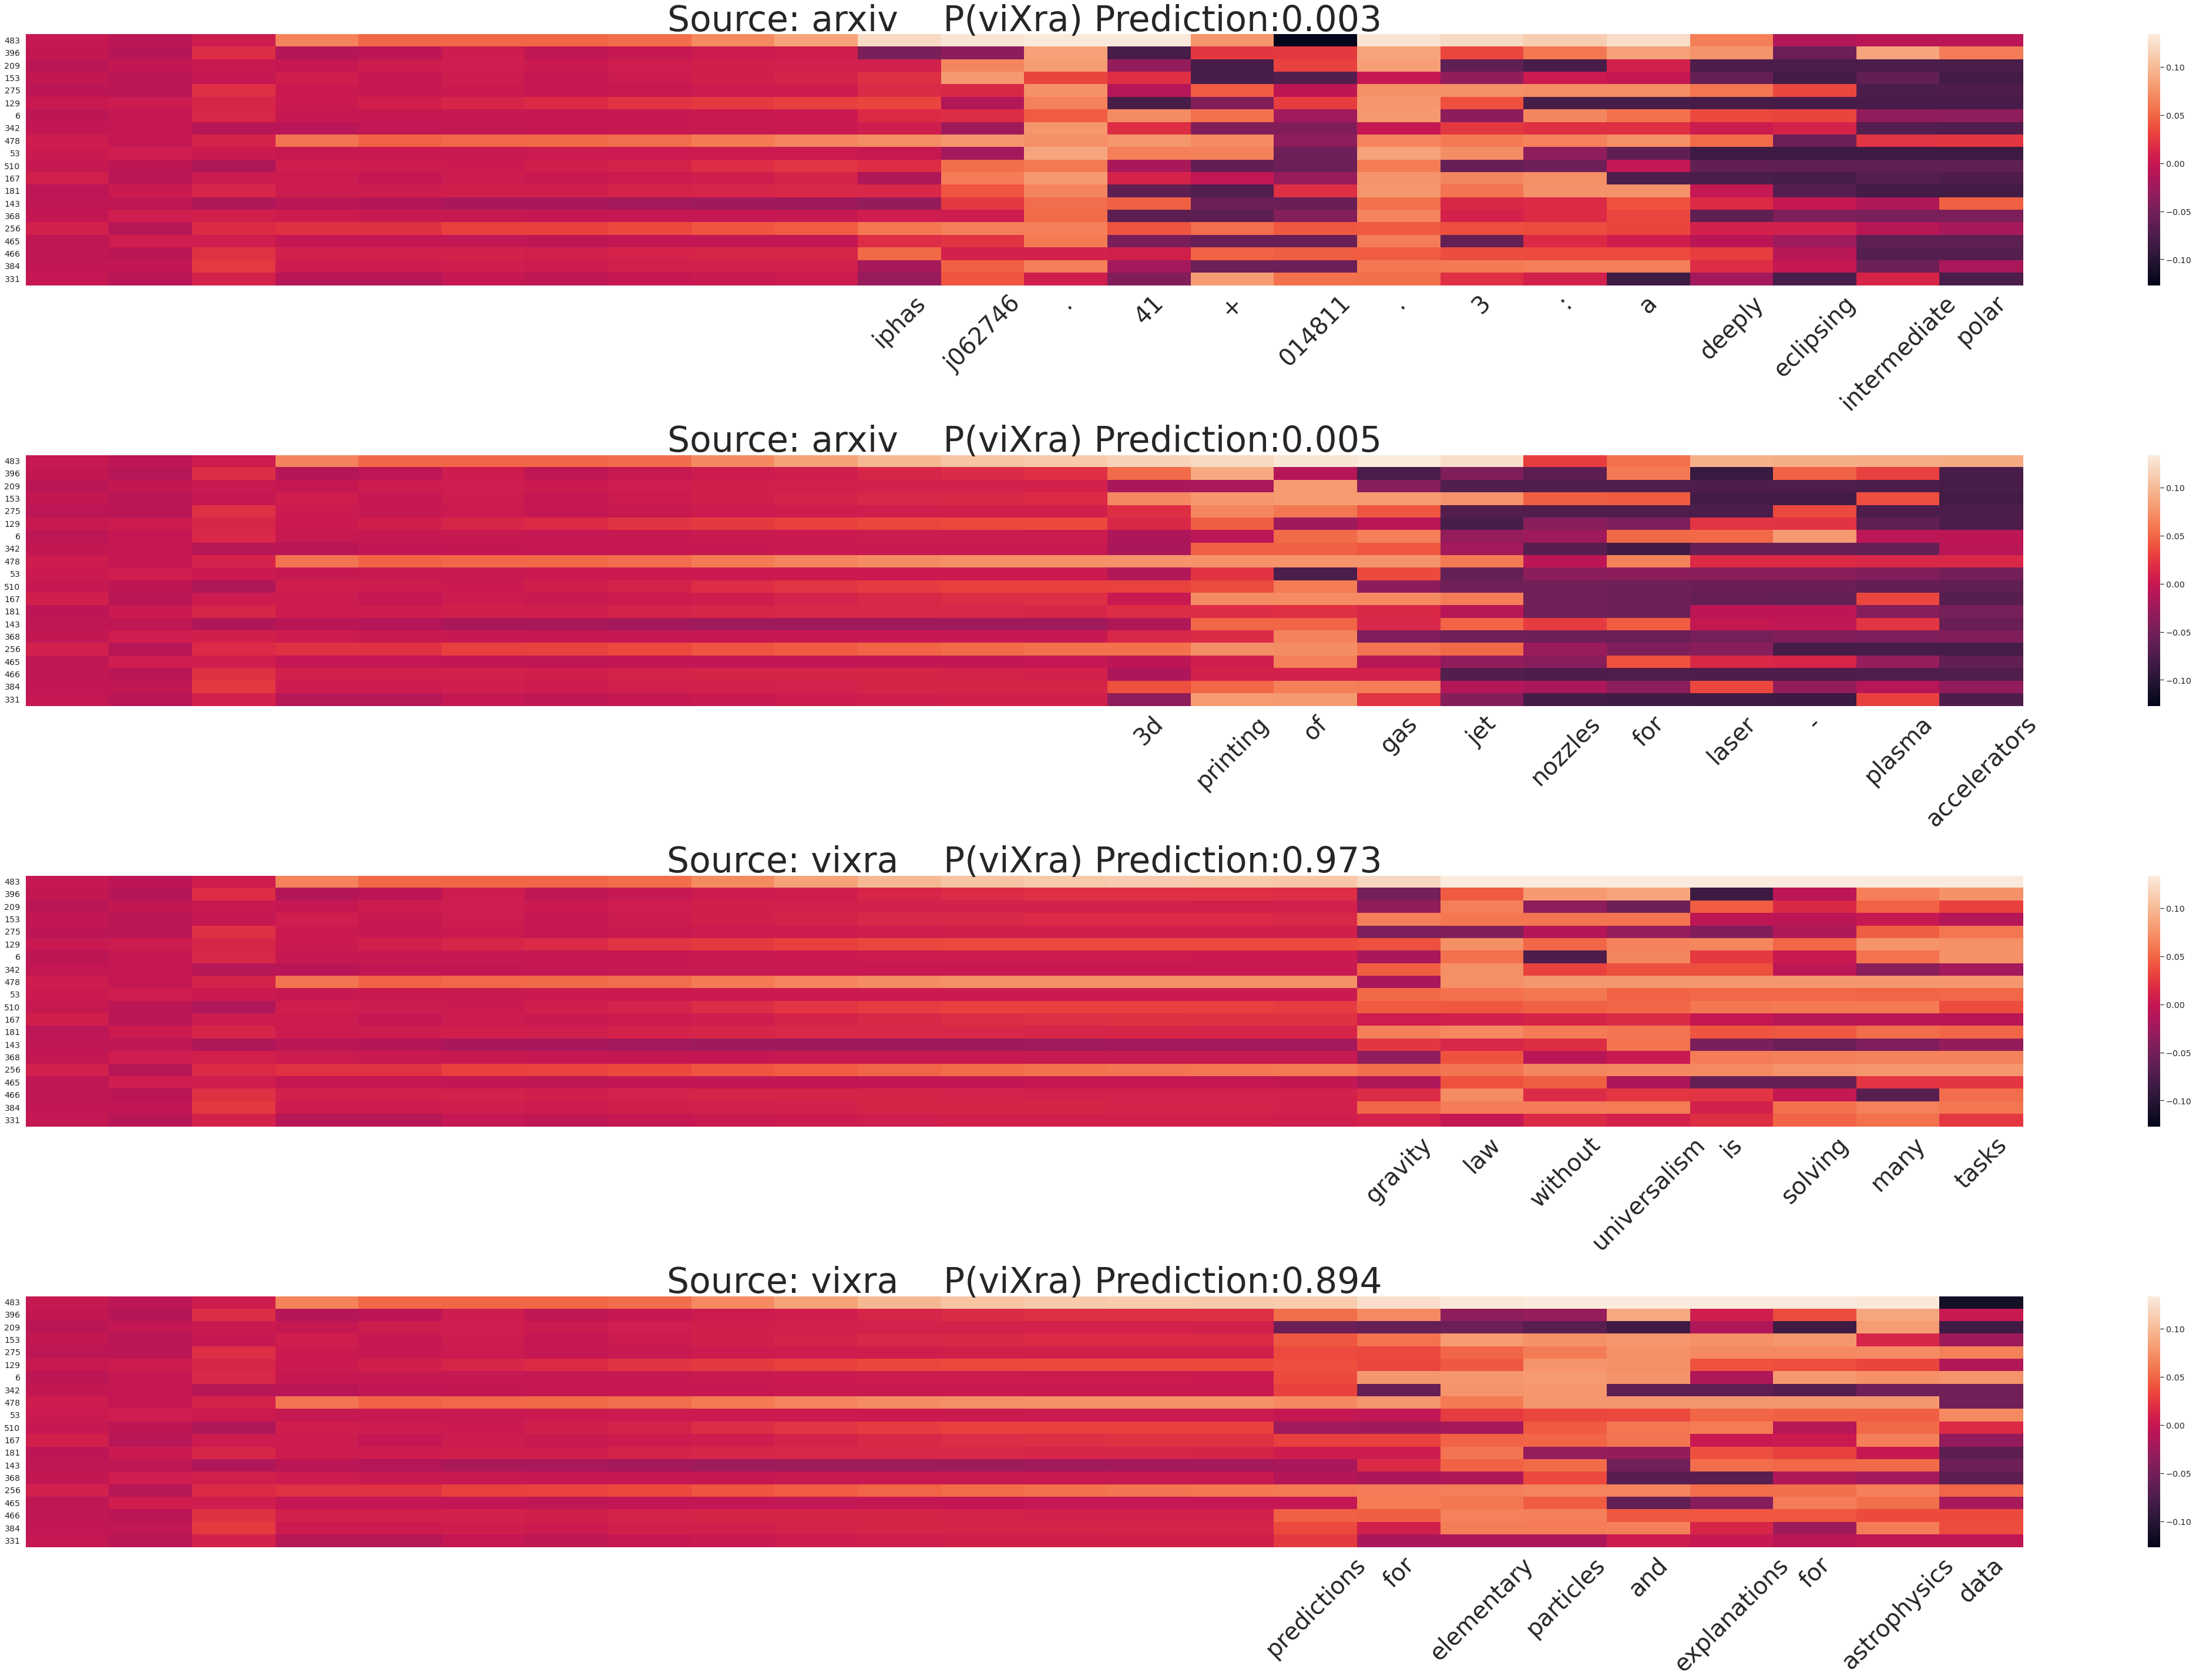

In [227]:
# Plot two randomly chosen arxiv and vixra titles, each.
train_text_arxiv_df = train_text_df[train_text_df['source'] == 'arxiv']
train_text_vixra_df = train_text_df[train_text_df['source'] == 'vixra']
excited_hidden_plot = excited_hidden_plotter(df=pd.concat([train_text_arxiv_df.sample(2),train_text_vixra_df.sample(2)]), k=20)

In [228]:
# excited_hidden_plot.savefig(FOLDERNAME + f'/figures/{PROJECT}_excited_neruons.svg', bbox_inches='tight')